In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, adjusted_rand_score

### Generate and visualize blobs
Easy to visually differentiate

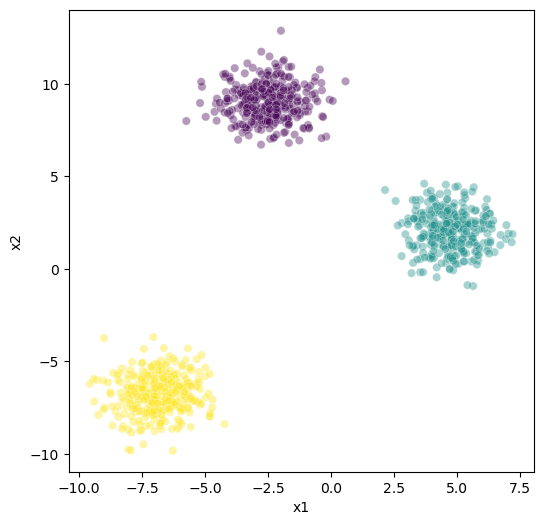

In [2]:
X, y = make_blobs(n_samples= 1000, centers= 3, n_features= 2, random_state= 42)
df = pd.DataFrame(X, columns= ['x1', 'x2'])
df['label'] = y


plt.figure(figsize= (6, 6))
sns.scatterplot(x= df.x1, y= df.x2, c= df.label, alpha= 0.4)
plt.show()

### Identify potential number of clusters
Examine the density plots

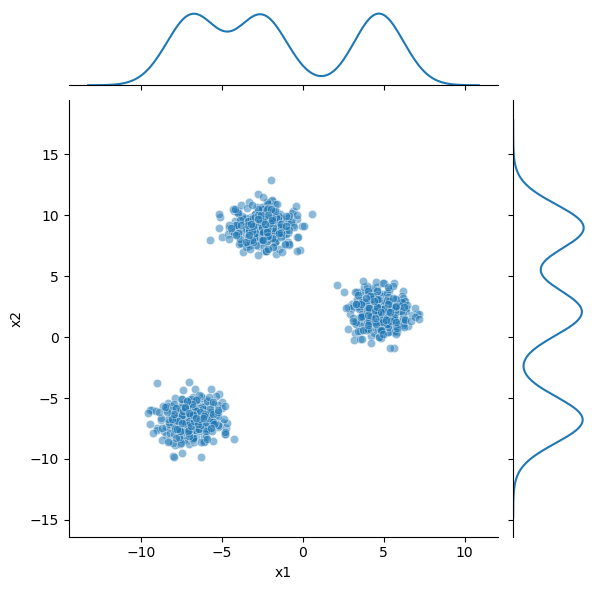

In [3]:
g = sns.JointGrid(data= df, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot);

### Increase the complexity of the data

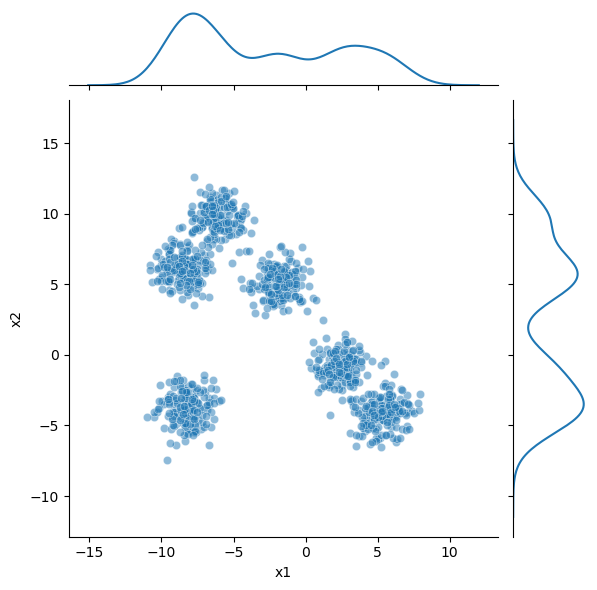

In [4]:
X, y = make_blobs(n_samples= 1000, centers= 6, n_features= 2, random_state= 4321)
df = pd.DataFrame(X, columns= ['x1', 'x2'])
df['label'] = y

g = sns.JointGrid(data= df, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot);

### Scale data

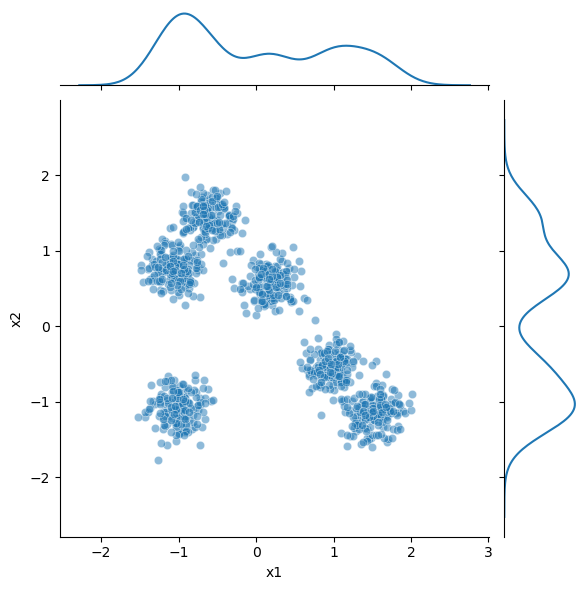

In [5]:
std_scaler = StandardScaler()
df_scaled = pd.DataFrame(std_scaler.fit_transform(df[['x1', 'x2']]), columns= ['x1', 'x2'])

g = sns.JointGrid(data= df_scaled, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot);

### Random initiallization of centroids

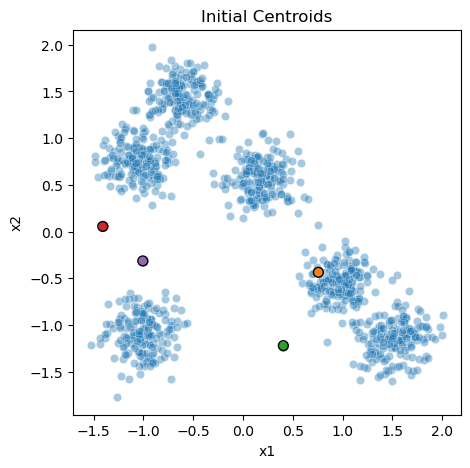

In [6]:
num_clusters= 4

centers = np.random.uniform(low= [df_scaled.x1.min(), df_scaled.x2.min()], 
                            high= [df_scaled.x1.max(), df_scaled.x2.max()], 
                            size= (num_clusters, 2))


plt.figure(figsize= (5, 5))
sns.scatterplot(x= df_scaled.x1, y= df_scaled.x2, alpha= 0.4)
for j in np.arange(len(centers)):
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
plt.title('Initial Centroids')    
plt.show()    

### Identify data points closest to nearest centroid

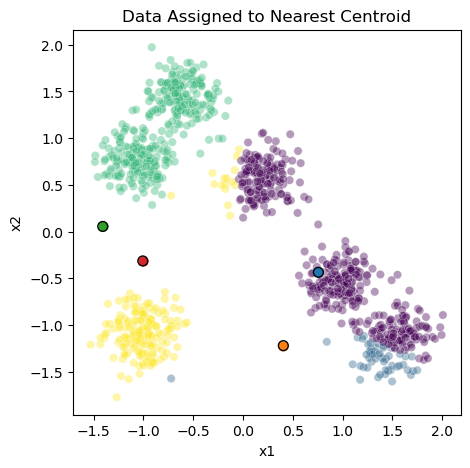

In [7]:
df_scaled.reset_index(inplace= True)
df_scaled.rename(columns= {'index':'pt'}, inplace= True)
df_scaled['key'] = 1

cent_df = pd.DataFrame(data= centers, columns= ['cent_x1', 'cent_x2'])
cent_df['label'] = np.arange(num_clusters)
cent_df['key'] = 1

df_scaled= \
df_scaled.merge(cent_df,
                on= 'key',
               )

df_scaled.drop(columns= ['key'], inplace= True)

df_scaled['cent_dist'] = (df_scaled.x1 - df_scaled.cent_x1)**2 + (df_scaled.x2 - df_scaled.cent_x2)**2

df_scaled = df_scaled.loc[df_scaled.groupby('pt').cent_dist.idxmin()]

label_centers =  df_scaled.groupby(['label'])[['x1', 'x2']].mean()


plt.figure(figsize= (5, 5))
sns.scatterplot(x= df_scaled.x1, y= df_scaled.x2, c= df_scaled.label, alpha= 0.4)
for j in np.arange(len(centers)):
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
plt.title(f'Data Assigned to Nearest Centroid')
plt.show()

### Calculate mean center of assigned data

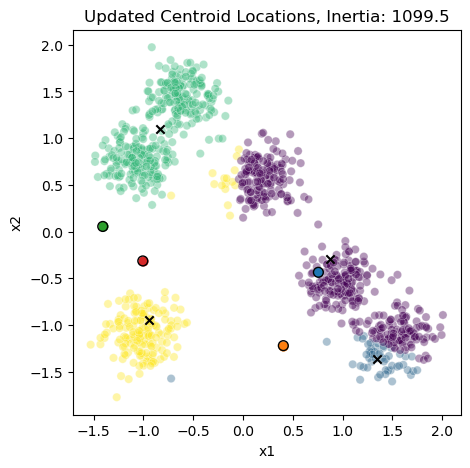

In [8]:
plt.figure(figsize= (5, 5))
sns.scatterplot(x= df_scaled.x1, y= df_scaled.x2, c= df_scaled.label, alpha= 0.4)
for j in np.arange(len(centers)):
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
plt.scatter(x= label_centers.x1, y= label_centers.x2, marker= 'x', color= 'black')    
plt.title(f'Updated Centroid Locations, Inertia: {np.round(df_scaled.cent_dist.sum(), 2)}')
plt.show()

### Centroid updating

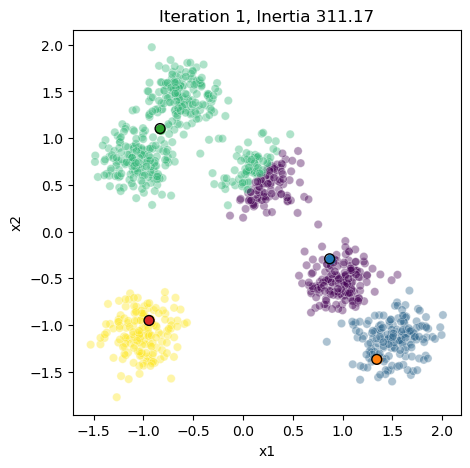

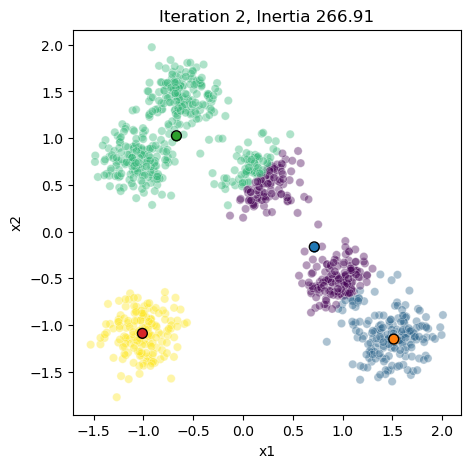

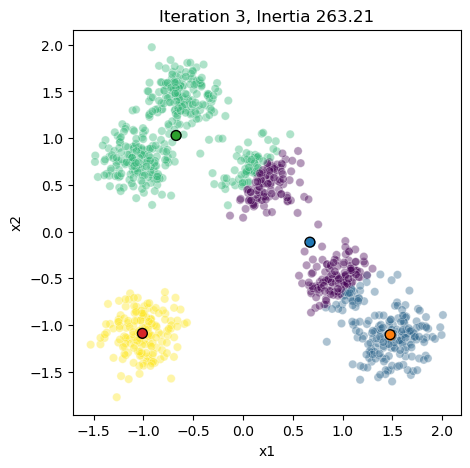

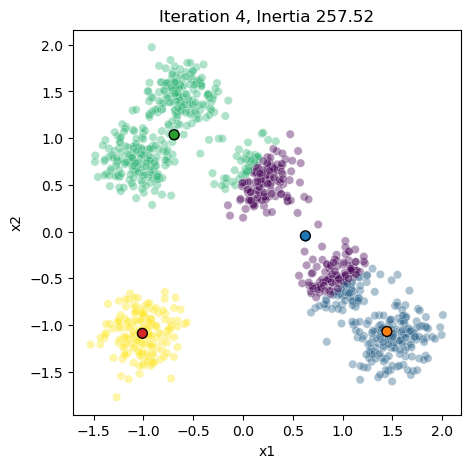

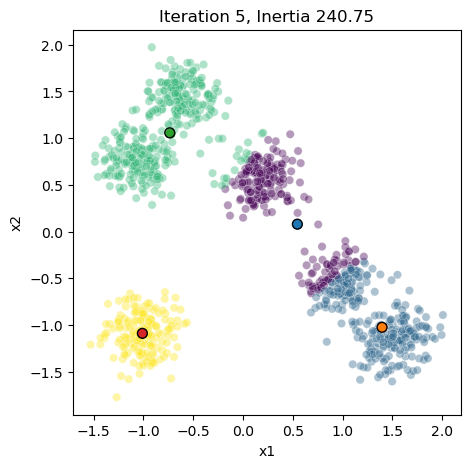

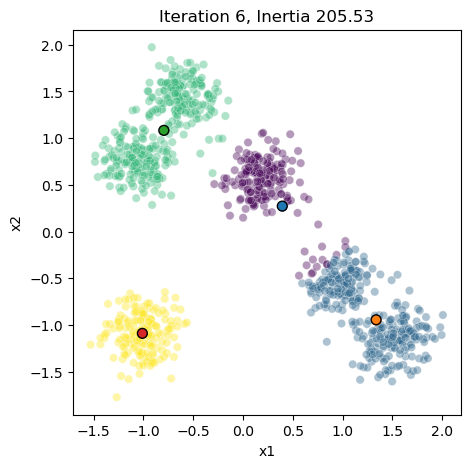

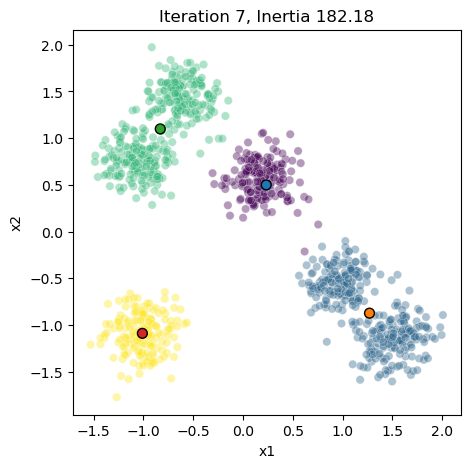

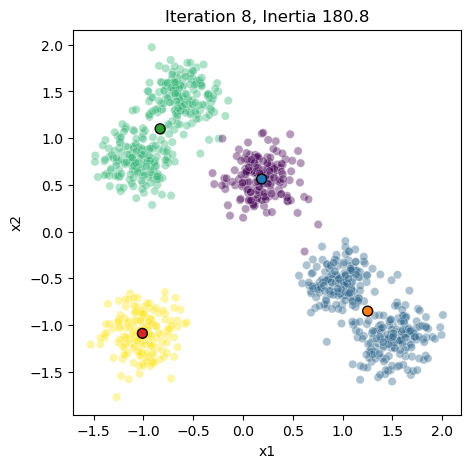

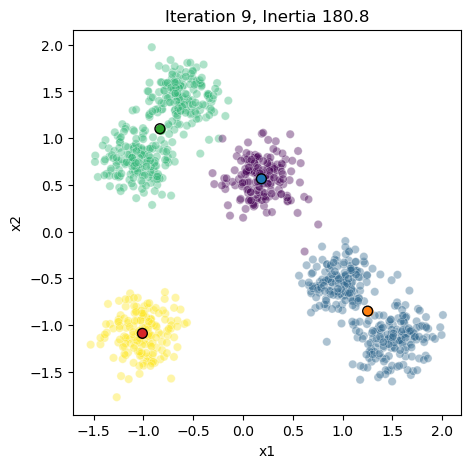

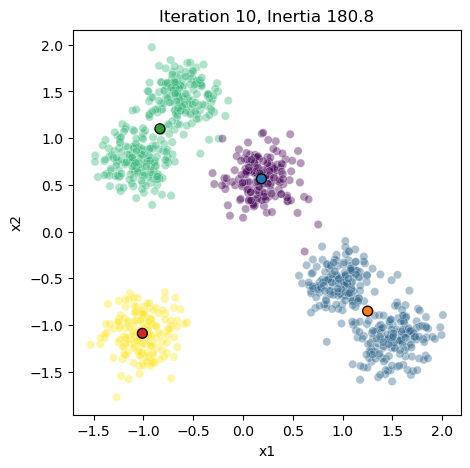

In [9]:
df_scaled = df_scaled[['x1', 'x2']]
df_scaled.reset_index(drop= True, inplace= True)

iterations = 10
inertia = np.array([])

for i in range(iterations):
    kmeans = KMeans(#init=(centers if centers is not None else 'random'), 
                    init= centers,
                    n_init= 1, 
                    max_iter= 1, 
                    n_clusters= num_clusters)
    kmeans.fit(df_scaled)
    centers = kmeans.cluster_centers_
    inertia = np.append(inertia, kmeans.inertia_)

    plt.figure(figsize= (5, 5))
    sns.scatterplot(x= df_scaled.x1, y= df_scaled.x2, c= kmeans.labels_, alpha= 0.4)
    for j in np.arange(len(centers)):
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
    plt.title(f'Iteration {i+1}, Inertia {np.round(kmeans.inertia_, 2)}')
    plt.show()

### Employ the Elbow Method to identify potential number of clusters

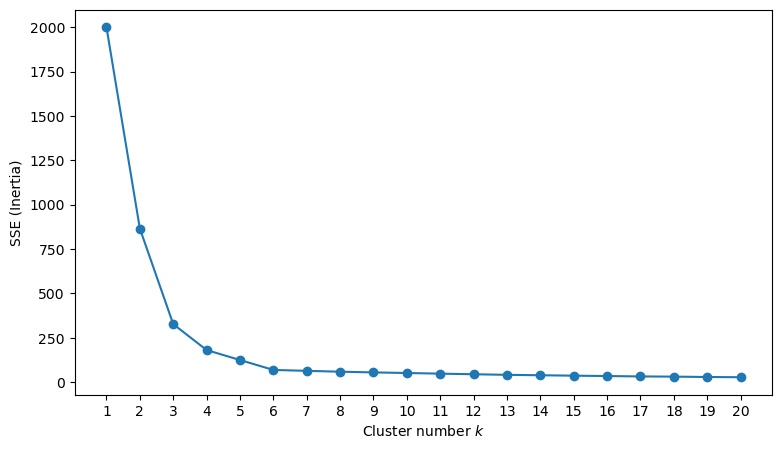

In [10]:
sse = np.empty((0, 2))
for k in np.arange(1, 21, 1):
    kmeans = KMeans(n_clusters= k, n_init= 10)
    kmeans.fit(df_scaled)
    sse = np.vstack([sse, np.array([k, kmeans.inertia_])])
    
plt.figure(figsize= (9, 5))
plt.scatter(x= sse[:, 0], y= sse[:, 1])
plt.plot(sse[:, 0], sse[:, 1])
plt.xlabel('Cluster number $k$')
plt.ylabel('SSE (Inertia)')
plt.xticks(ticks= np.arange(1, 21, 1))
plt.show()

## Silhouette Analysis

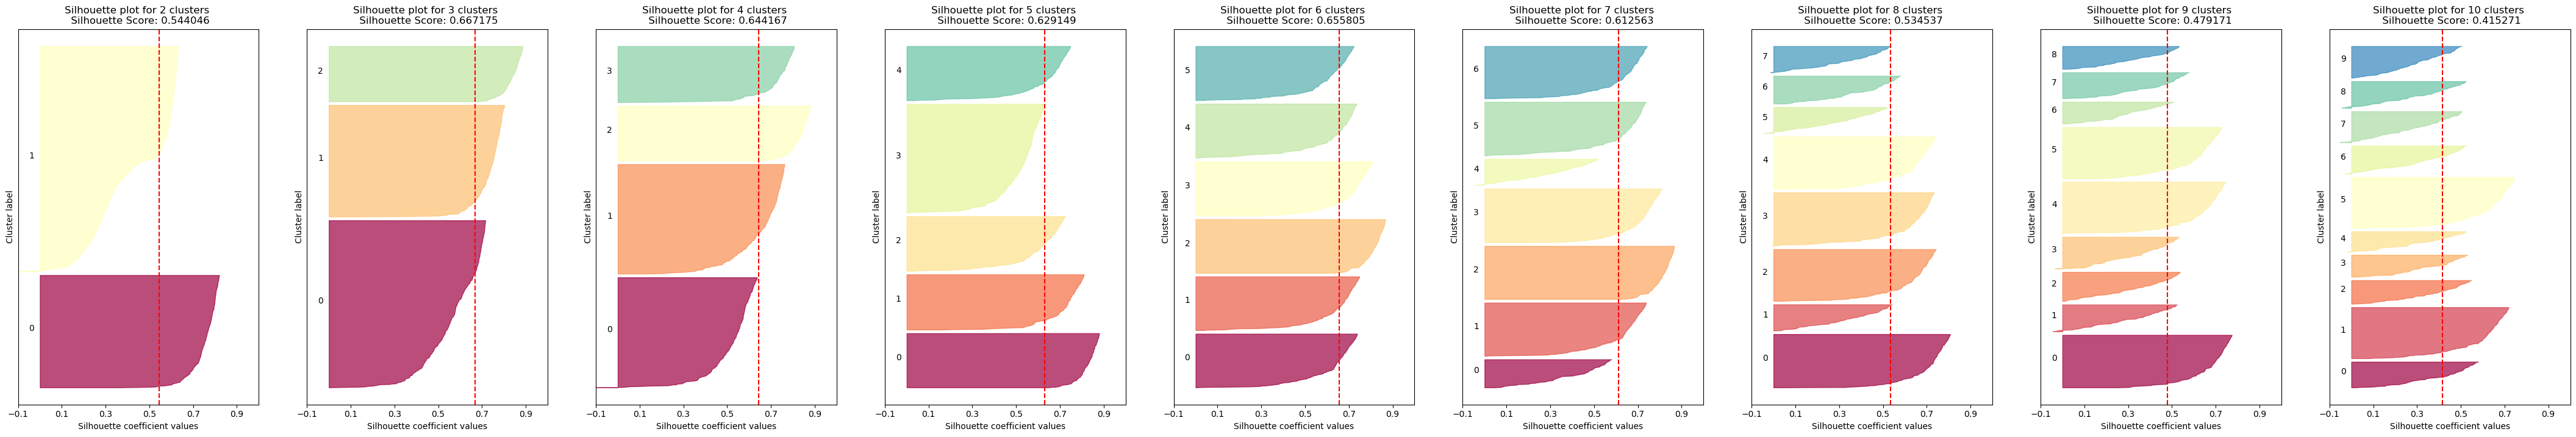

In [11]:
silhouette_value_by_k = np.empty((0, 2))

k_values = np.arange(2, 11, 1)
plt.figure(figsize=(len(k_values) * 6, 8))

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters= k, n_init= 10)
    labels = kmeans.fit_predict(df_scaled)
    
    silhouette_values = silhouette_samples(df_scaled, labels)
    
    silhouette_value_by_k = np.vstack([silhouette_value_by_k, [k, silhouette_values.mean()]])
    
    plt.subplot(1, len(k_values), i + 1)
    y_lower= 10
    for j in range(k):
        ith_cluster_silhouette_values = silhouette_values[labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        
        color = plt.colormaps.get_cmap("Spectral")(float(j) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    plt.title(f"Silhouette plot for {k} clusters \n Silhouette Score: {round(silhouette_values.mean(), 6)}")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x= silhouette_values.mean(), color="red", linestyle="--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

### Silhouette Score versus number of clusters

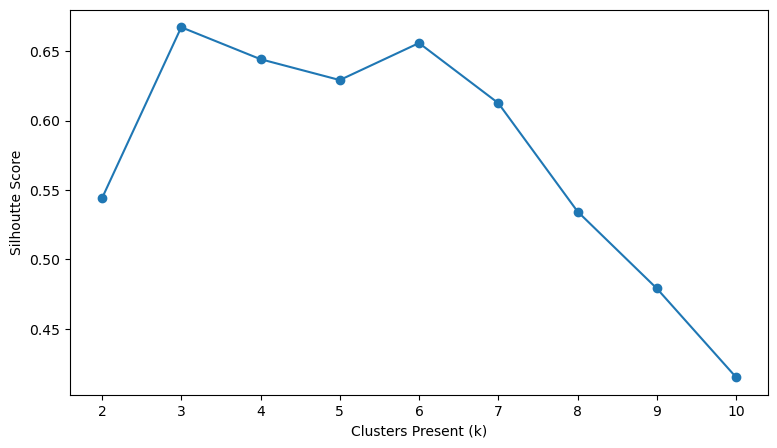

In [12]:
plt.figure(figsize= (9, 5))
plt.scatter(x= silhouette_value_by_k[:, 0], y= silhouette_value_by_k[:, 1])
plt.plot(silhouette_value_by_k[:, 0], silhouette_value_by_k[:, 1])
plt.ylabel('Silhoutte Score')
plt.xlabel('Clusters Present (k)')
plt.show()

### Cluster with optimal number

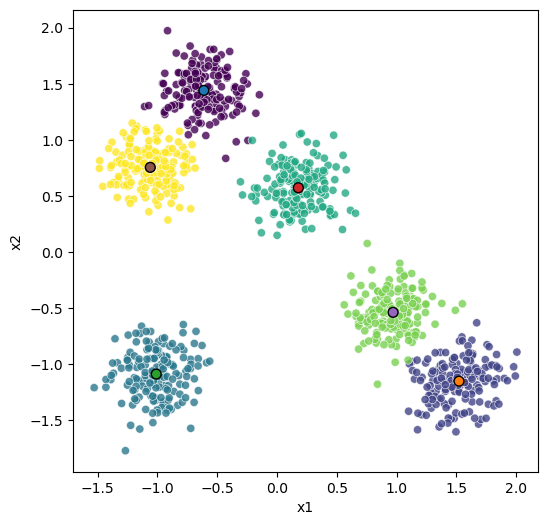

In [13]:
kmeans_6 = KMeans(n_clusters= 6, n_init= 'auto')
kmeans_6.fit(df_scaled)
centers = kmeans_6.cluster_centers_
    
plt.figure(figsize= (6, 6))
sns.scatterplot(x= df_scaled.x1, y= df_scaled.x2, c= kmeans_6.labels_, alpha= 0.8)
for j in np.arange(len(centers)):
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
plt.show()

In [14]:
adjusted_rand_score(y, kmeans_6.labels_)

0.9738705669070494

## Obviously poor clustering

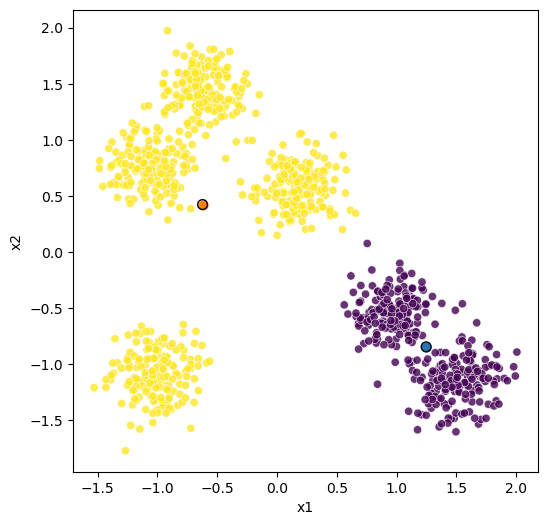

In [15]:
kmeans_2 = KMeans(n_clusters= 2, n_init= 'auto')
kmeans_2.fit(df_scaled)
centers = kmeans_2.cluster_centers_
    
plt.figure(figsize= (6, 6))
sns.scatterplot(x= df_scaled.x1, y= df_scaled.x2, c= kmeans_2.labels_, alpha= 0.8)
for j in np.arange(len(centers)):
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
plt.show()

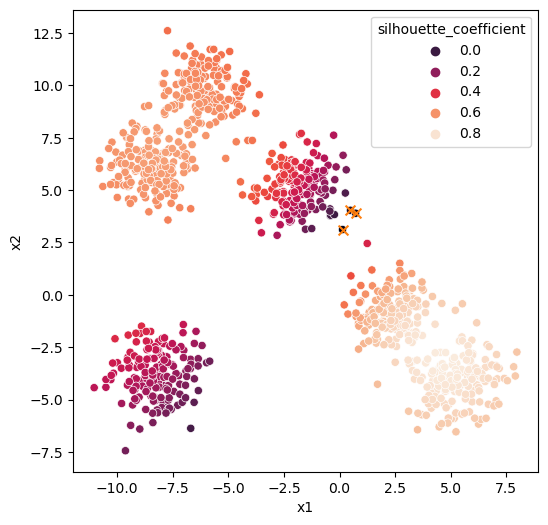

In [16]:
X_df = pd.DataFrame(X, columns= ['x1', 'x2'])
X_df['silhouette_coefficient']  = silhouette_samples(df_scaled, kmeans_2.labels_)
X_df['label'] = kmeans.labels_

plt.figure(figsize= (6, 6))
sns.scatterplot(x= X_df.x1, y= X_df.x2, hue= X_df.silhouette_coefficient, palette= 'rocket')
plt.scatter(x= X_df[X_df.silhouette_coefficient < 0].x1, y= X_df[X_df.silhouette_coefficient < 0].x2, marker= 'x', s= 50)
plt.show()

### Davies-Bouldin Index

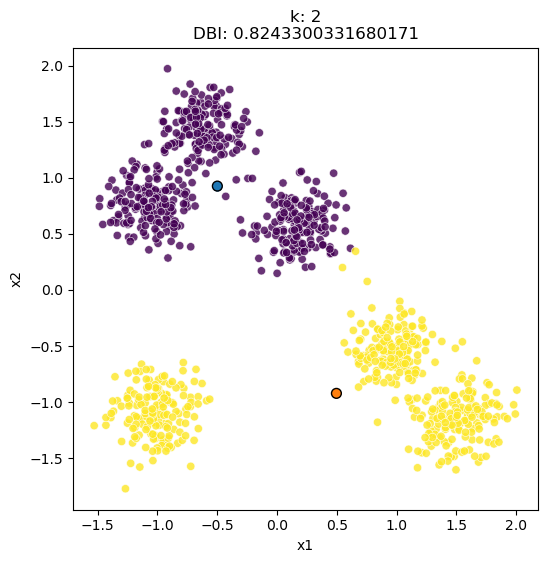

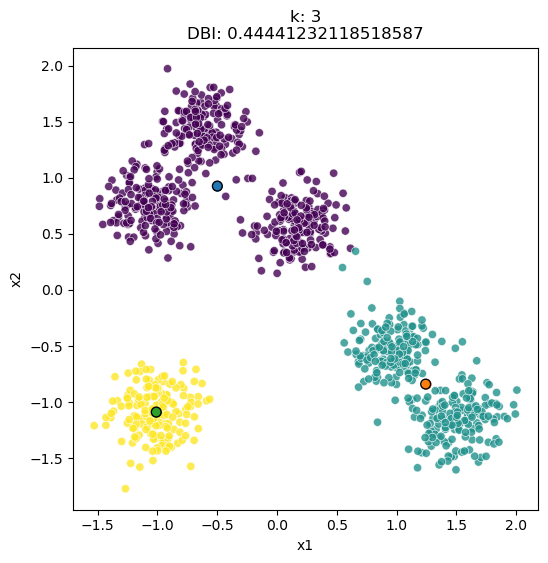

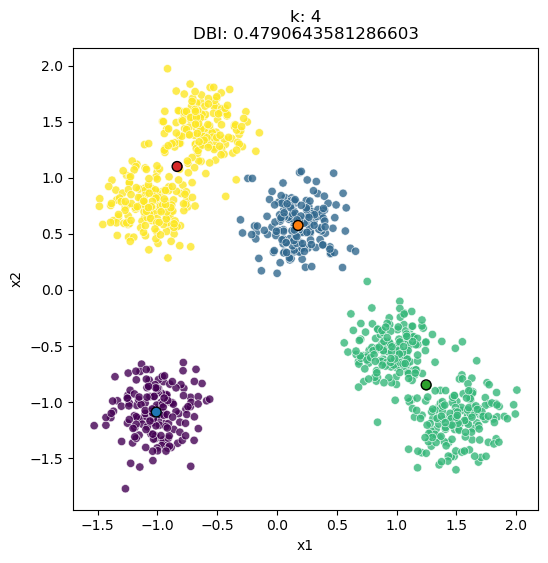

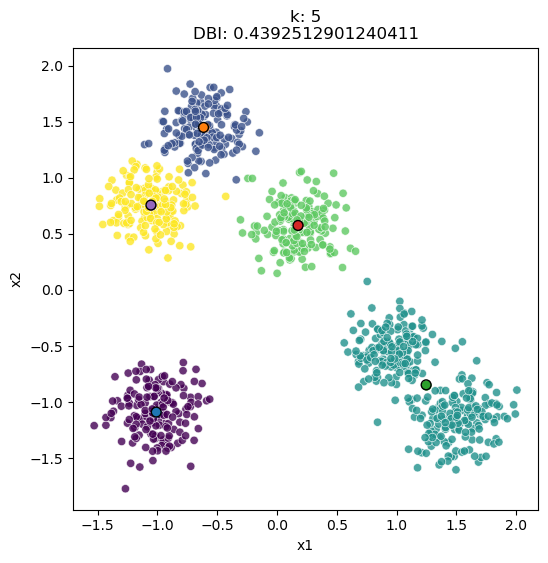

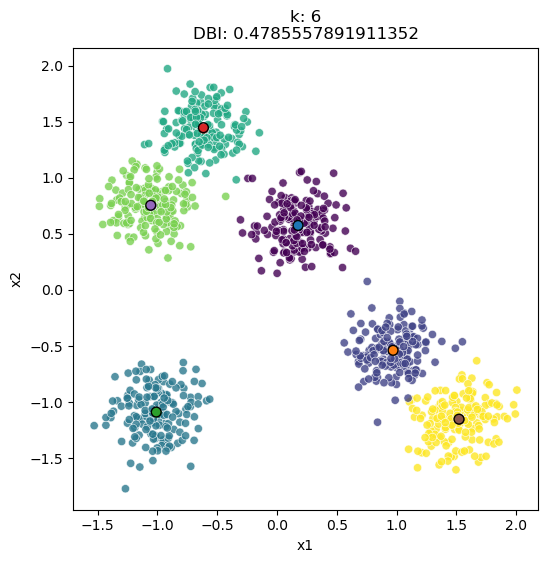

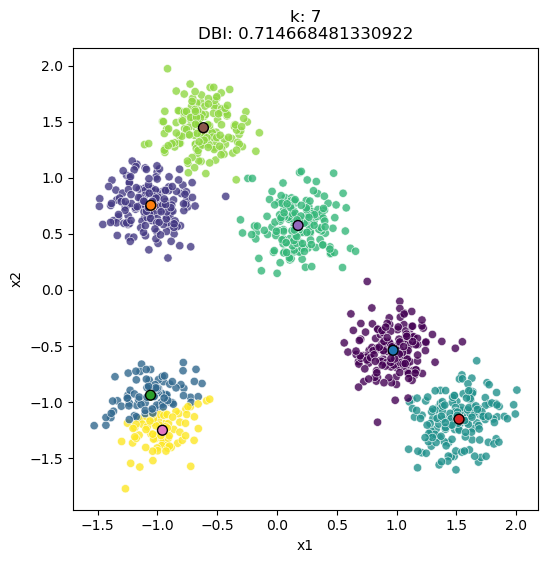

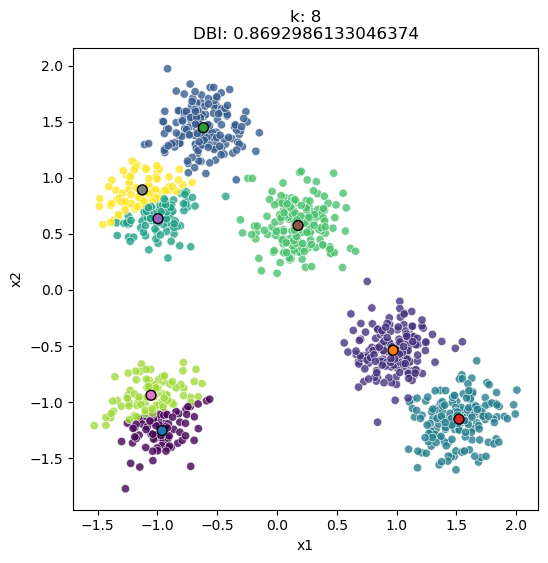

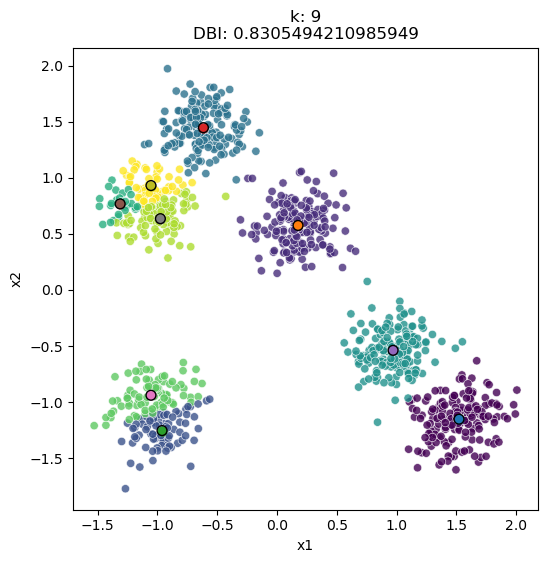

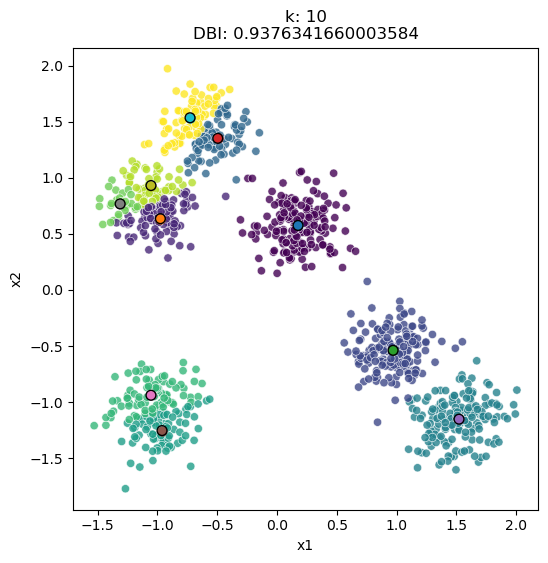

In [17]:
for k in np.arange(2, 11, 1):
    kmeans = KMeans(n_clusters= k, n_init= 'auto')
    kmeans.fit(df_scaled)
    centers = kmeans.cluster_centers_
    df_scaled['label'] = kmeans.labels_

    plt.figure(figsize= (6, 6))
    sns.scatterplot(x= df_scaled.x1, y= df_scaled.x2, c= kmeans.labels_, alpha= 0.8)
    for j in np.arange(len(centers)):
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
    plt.title(f'k: {k}\nDBI: {davies_bouldin_score(X= df_scaled[["x1", "x2"]], labels= df_scaled.label)    }')
    plt.show()

### Imbalanced Populations

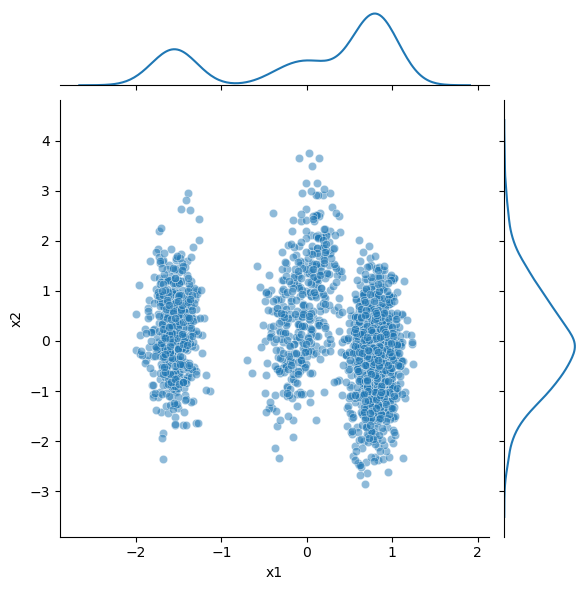

In [18]:
X_imb, y_imb = make_blobs(n_samples= [1000, 500, 200, 100, 100], n_features= 2, random_state= None, cluster_std= 1)
df_imb = pd.DataFrame(X_imb, columns= ['x1', 'x2'])
df_imb['label'] = y_imb

std_scaler = StandardScaler()
df_imb_scaled = pd.DataFrame(std_scaler.fit_transform(df_imb[['x1', 'x2']]), columns= ['x1', 'x2'])

g = sns.JointGrid(data= df_imb_scaled, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot);

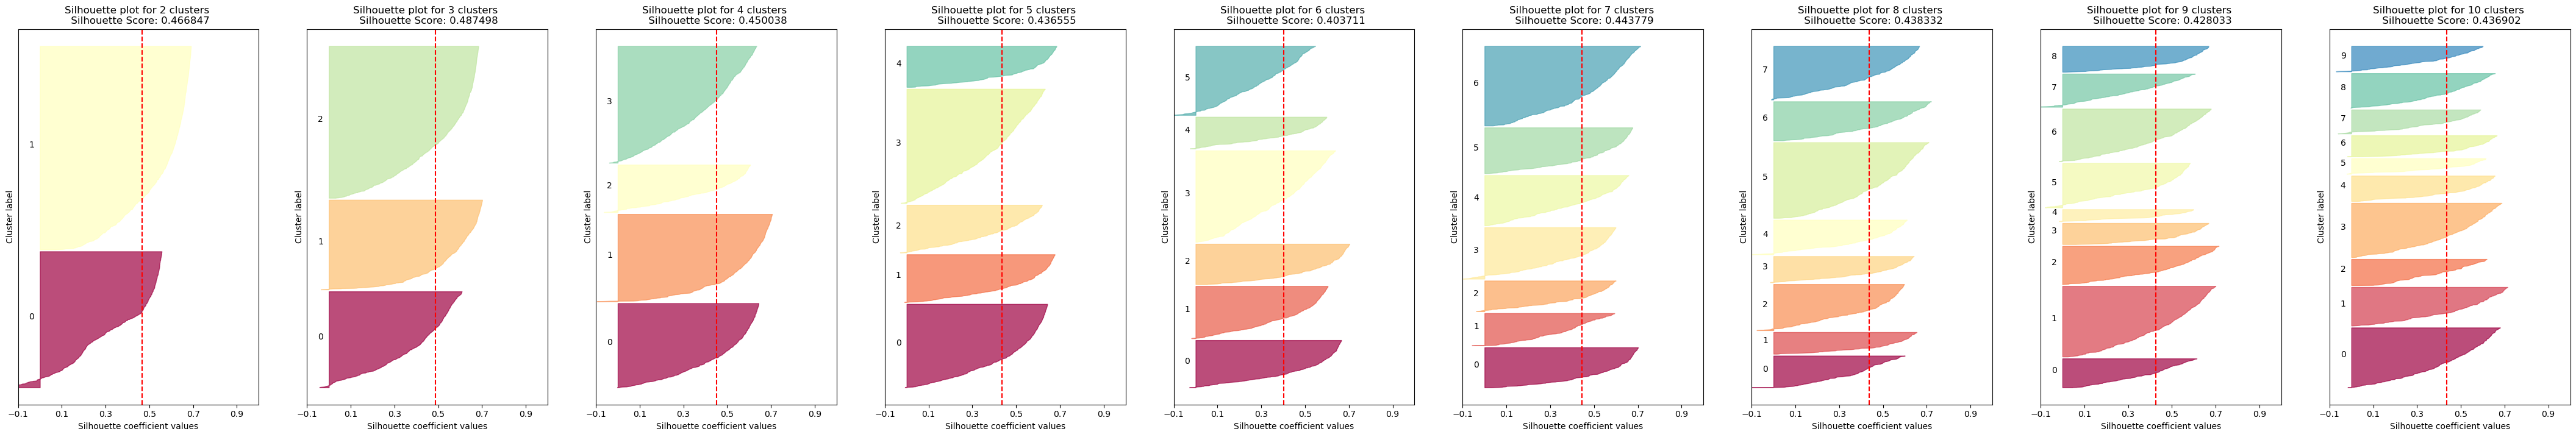

In [19]:
k_values = np.arange(2, 11, 1)
plt.figure(figsize=(len(k_values) * 6, 8))

silhouette_value_by_k = np.empty((0, 2))

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters= k, n_init= 10)
    labels = kmeans.fit_predict(df_imb_scaled)
    
    silhouette_values = silhouette_samples(df_imb_scaled, labels)

    silhouette_value_by_k = np.vstack([silhouette_value_by_k, [k, silhouette_values.mean()]])
    
    plt.subplot(1, len(k_values), i + 1)
    y_lower= 10
    for j in range(k):
        ith_cluster_silhouette_values = silhouette_values[labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        
        color = plt.colormaps.get_cmap("Spectral")(float(j) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    plt.title(f"Silhouette plot for {k} clusters \n Silhouette Score: {round(silhouette_values.mean(), 6)}")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x= silhouette_values.mean(), color="red", linestyle="--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

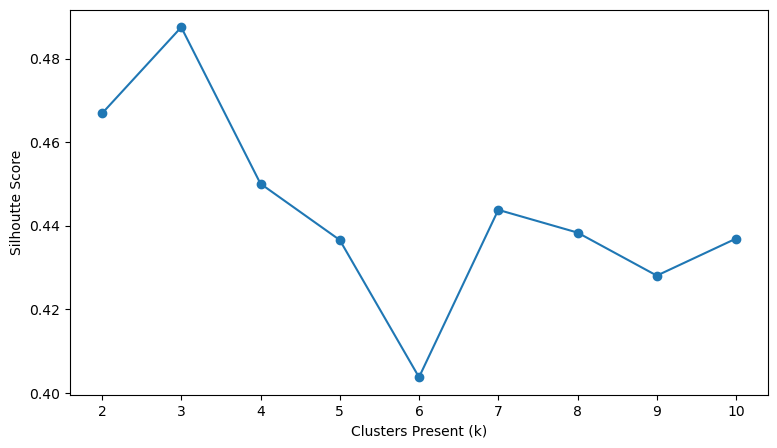

In [20]:
plt.figure(figsize= (9, 5))
plt.scatter(x= silhouette_value_by_k[:, 0], y= silhouette_value_by_k[:, 1])
plt.plot(silhouette_value_by_k[:, 0], silhouette_value_by_k[:, 1])
plt.ylabel('Silhoutte Score')
plt.xlabel('Clusters Present (k)')
plt.show()

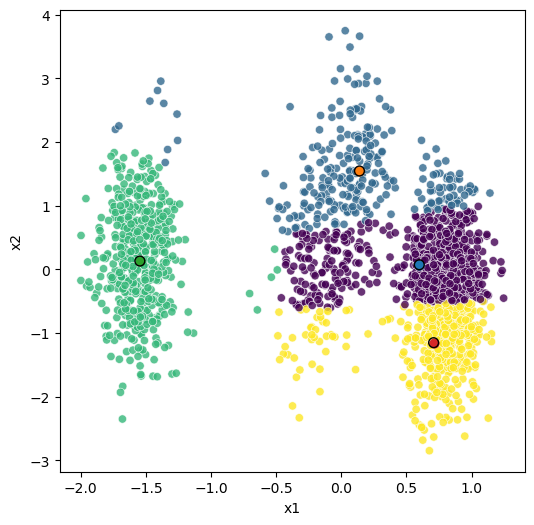

In [21]:
kmeans = KMeans(n_clusters= 4, n_init= 'auto')
kmeans.fit(df_imb_scaled)
centers = kmeans.cluster_centers_
    
plt.figure(figsize= (6, 6))
sns.scatterplot(x= df_imb_scaled.x1, y= df_imb_scaled.x2, c= kmeans.labels_, alpha= 0.8)
for j in np.arange(len(centers)):
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
plt.show()

In [22]:
adjusted_rand_score(labels_true= y_imb, labels_pred= kmeans.labels_)

0.4651708559267399

### Non-blob clusters

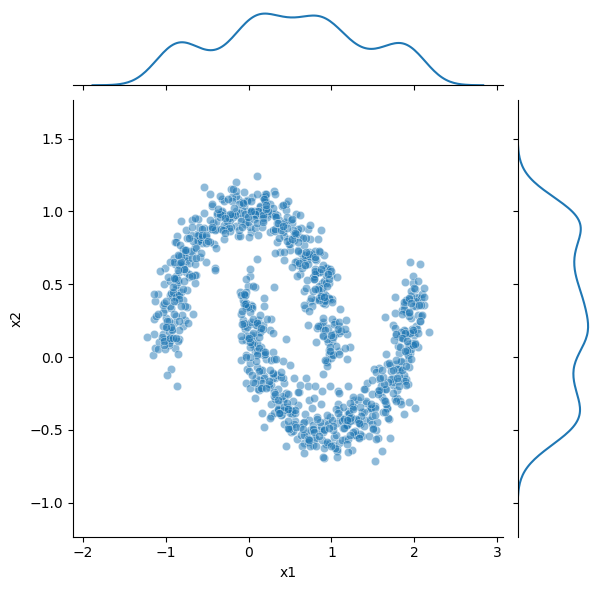

In [24]:
X_moon, y_moon = make_moons(n_samples= 1000, noise= 0.1)
#X_moon, y_moon = make_circles(n_samples= 1000, noise= 0.1, factor= 0.6)

df_moon = pd.DataFrame(X_moon, columns= ['x1', 'x2'])
df_moon['label'] = y_moon

g = sns.JointGrid(data= df_moon, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot);

In [25]:
df_moon_scaled = pd.DataFrame(std_scaler.fit_transform(df_moon[['x1', 'x2']]), columns= ['x1', 'x2'])

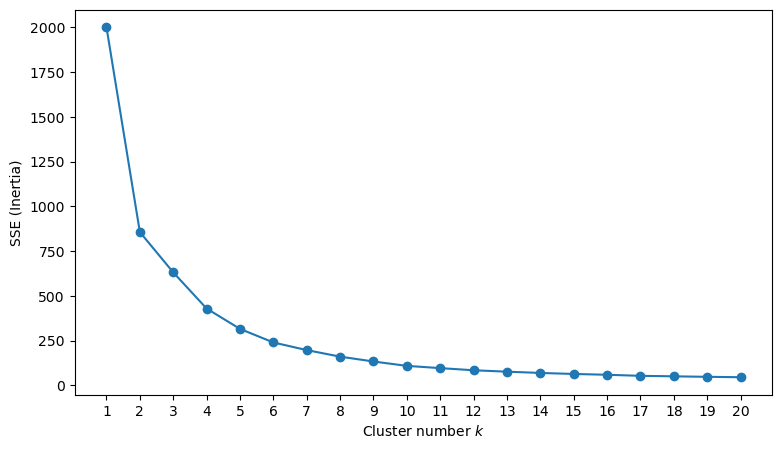

In [26]:
sse = np.empty((0, 2))
for k in np.arange(1, 21, 1):
    kmeans = KMeans(n_clusters= k, n_init= 10)
    kmeans.fit(df_moon_scaled)
    sse = np.vstack([sse, np.array([k, kmeans.inertia_])])
    
plt.figure(figsize= (9, 5))
plt.scatter(x= sse[:, 0], y= sse[:, 1])
plt.plot(sse[:, 0], sse[:, 1])
plt.xlabel('Cluster number $k$')
plt.ylabel('SSE (Inertia)')
plt.xticks(ticks= np.arange(1, 21, 1))
plt.show()

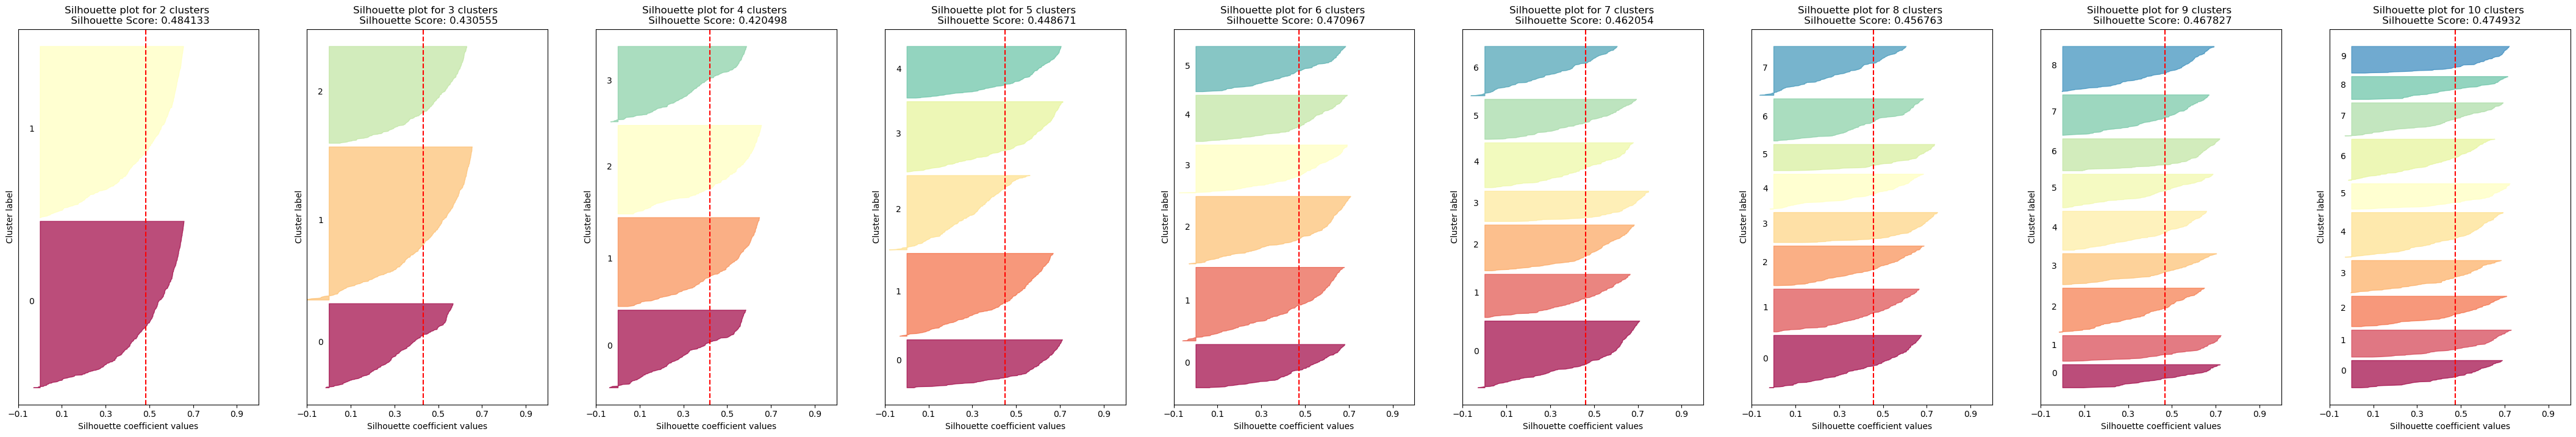

In [27]:
silhouette_value_by_k = np.empty((0, 2))

k_values = np.arange(2, 11, 1)
plt.figure(figsize=(len(k_values) * 6, 8))

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters= k, n_init= 10)
    labels = kmeans.fit_predict(df_moon_scaled)
    
    silhouette_values = silhouette_samples(df_moon_scaled, labels)
    
    silhouette_value_by_k = np.vstack([silhouette_value_by_k, [k, silhouette_values.mean()]])
    
    plt.subplot(1, len(k_values), i + 1)
    y_lower= 10
    for j in range(k):
        ith_cluster_silhouette_values = silhouette_values[labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        
        color = plt.colormaps.get_cmap("Spectral")(float(j) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    plt.title(f"Silhouette plot for {k} clusters \n Silhouette Score: {round(silhouette_values.mean(), 6)}")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x= silhouette_values.mean(), color="red", linestyle="--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

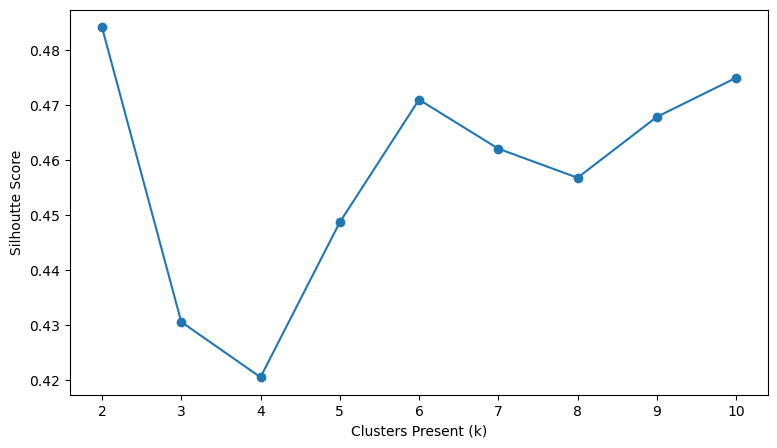

In [28]:
plt.figure(figsize= (9, 5))
plt.scatter(x= silhouette_value_by_k[:, 0], y= silhouette_value_by_k[:, 1])
plt.plot(silhouette_value_by_k[:, 0], silhouette_value_by_k[:, 1])
plt.ylabel('Silhoutte Score')
plt.xlabel('Clusters Present (k)')
plt.show()

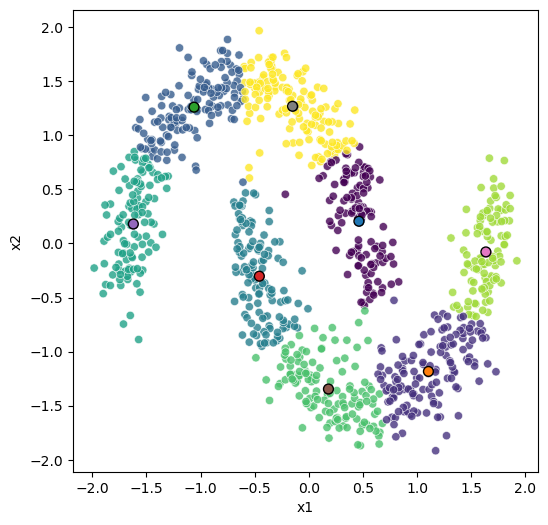

In [29]:
kmeans_moon = KMeans(n_clusters= 8, n_init= 'auto')
kmeans_moon.fit(df_moon_scaled)
centers = kmeans_moon.cluster_centers_
    
plt.figure(figsize= (6, 6))
sns.scatterplot(x= df_moon_scaled.x1, y= df_moon_scaled.x2, c= kmeans_moon.labels_, alpha= 0.8)
for j in np.arange(len(centers)):
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
plt.show()

In [30]:
adjusted_rand_score(labels_true= y_moon, labels_pred= kmeans_moon.labels_)

0.2428356126194257

In [31]:
davies_bouldin_score(X= df_moon_scaled[["x1", "x2"]], labels= kmeans_moon.labels_)

0.7172142606782053